In [35]:
import json
import numpy as np 
import nltk
import pandas as pd
import pickle
import string
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
import matplotlib.pyplot as plt
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing.label import MultiLabelBinarizer 

## Tutorial from https://towardsdatascience.com/dating-algorithms-using-machine-learning-and-ai-814b68ecd75e
## Learned how to tokenize and lemmatize words for clustering 

In [39]:
with open("profiles.pkl",'rb') as fp:
    df = pickle.load(fp)
df.drop('Cluster #', axis = 1,inplace = True)

In [40]:
lemmatizer = WordNetLemmatizer()
# Instantiating the Scaler
scaler = MinMaxScaler()
# Scaling the categories then replacing the old values
df = df[['Bios']].join(
              pd.DataFrame(
          scaler.fit_transform(
                               df.drop('Bios',axis=1)), 
                               columns=df.columns[1:], 
                               index=df.index))
# Tokenizing Function
def tokenize(text):
    """
    Tokenizing the bios, then lemmatizing them
    """
    # Creating a library of stopwords
    stops = stopwords.words('english')
    
    # Lowercasing the words
    text = text.lower()
    
    # Removing the punctuations (periods)
    text = text.replace('.', '')
    
    # Splitting on spaces between words
    text = text.split(' ')
    
    # Lemmatizing the words and removing stop words
    text = [lemmatizer.lemmatize(i) for i in text if i not in stops]
    
    return text
    
# Applying the function to each user bio
df['Bios'] = df.Bios.apply(tokenize)

In [4]:
tags = []
for x in df['Bios']:
    tagged = nltk.pos_tag(x)
    tags.append(tagged)
tags[0]

[('typical', 'JJ'),
 ('twitter', 'NN'),
 ('fanatic', 'JJ'),
 ('infuriatingly', 'RB'),
 ('humble', 'JJ'),
 ('thinker', 'NN'),
 ('lifelong', 'JJ'),
 ('coffee', 'NN'),
 ('practitioner', 'NN'),
 ('organizer', 'NN')]

Number of unique words:  104


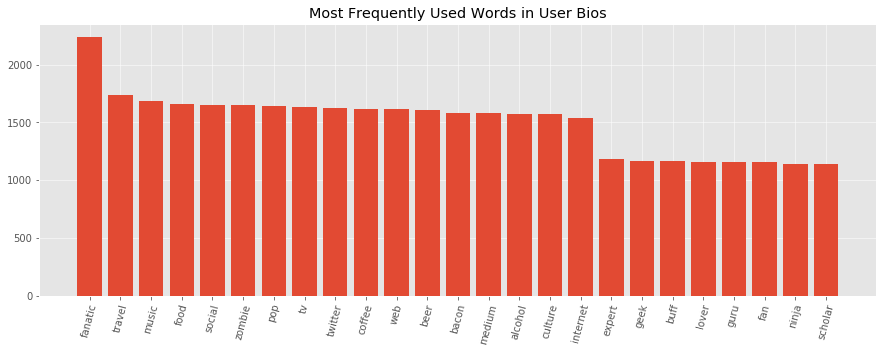

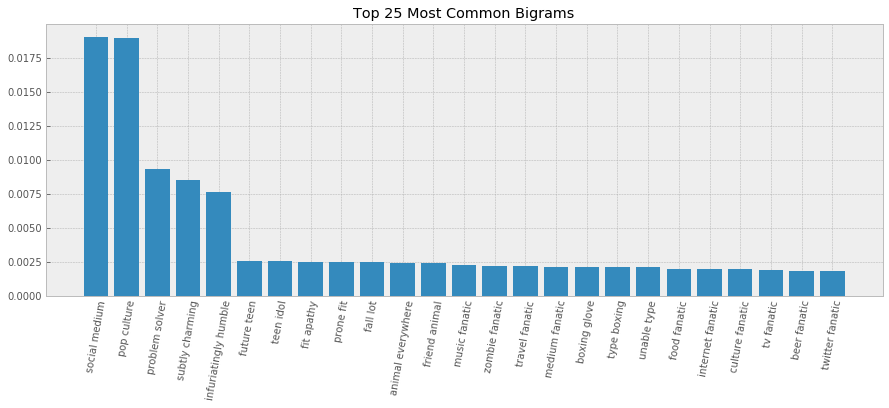

In [50]:

total_vocab = set()

# Iterating through the bios for each word
for bio in df['Bios']:
    total_vocab.update(bio)

# Printing out the number of unique words in all the bios combined
print("Number of unique words: ",len(total_vocab))

# Determining the most frequent words in user bios
words = []

# Adding all the words in each bio to a list
for bio in df['Bios']:
    words.extend(bio)

# Determining the use frequency of each word in all the bios
bio_freq = FreqDist(words)
bio_freq.most_common(104)

# Plotting the most frequently used words
plt.style.use('ggplot')
plt.figure(figsize=(15,5))

plt.bar(*zip(*bio_freq.most_common(25)))
plt.xticks(rotation=75)
plt.title('Most Frequently Used Words in User Bios')
plt.show()

bigram_meas = BigramAssocMeasures()

# Finding and ranking the Bigrams in each bio
bio_finder = BigramCollocationFinder.from_words(words)

# Finding the frequency scores of each bigram 
bio_scored = bio_finder.score_ngrams(bigram_meas.raw_freq)

# Top 50 most common bigrams
bio_scored[:50]

# Creating a list of the bigrams
bg = list(map(lambda x: x[0][0] + ' ' + x[0][1], bio_scored[:50]))

# Creating a list of the frequency scores
bio_scores = list(map(lambda x: x[1], bio_scored[:50]))

# Combining both the scores and the bigrams
bigrams = list(zip(bg, bio_scores))

# Plotting the bigrams and their frequency scores
plt.style.use('bmh')
plt.figure(figsize=(15,5))

plt.bar(*zip(*bigrams[:25]))
plt.xticks(rotation=80)
plt.title('Top 25 Most Common Bigrams')
plt.show()

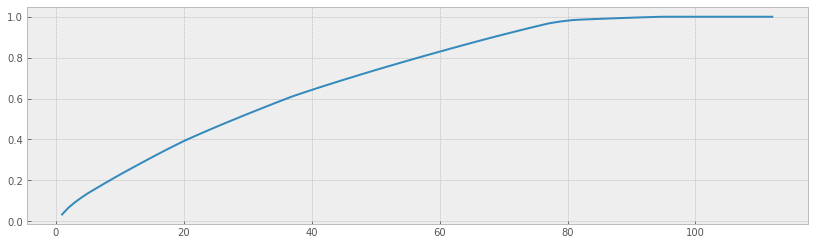

Number features: 74
Total Variance Explained: 0.9522246788637657
0.9446336085656274


In [47]:
# Instantiating PCA
pca = PCA()

# Fitting and Transforming the DF
df_pca = pca.fit_transform(new_df)

# Plotting to determine how many features should the dataset be reduced to
plt.style.use("bmh")
plt.figure(figsize=(14,4))
plt.plot(range(1,new_df.shape[1]+1), pca.explained_variance_ratio_.cumsum())
plt.show()

# Finding the exact number of features that explain at least 95% of the variance in the dataset
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance>=.95])
n_to_reach_95 = new_df.shape[1] - n_over_95

# Printing out the number of features needed to retain 95% variance
print(f"Number features: {n_to_reach_95}\nTotal Variance Explained: {total_explained_variance[n_to_reach_95]}")

# Reducing the dataset to the number of features determined before
pca = PCA(n_components=n_to_reach_95)

# Fitting and transforming the dataset to the stated number of features and creating a new DF
df_pca = pca.fit_transform(new_df)

# Seeing the variance ratio that still remains after the dataset has been reduced
print(pca.explained_variance_ratio_.cumsum()[-1])

In [51]:
vectorizer = CountVectorizer()
#vectorizer = TfidfVectorizer()

# Fitting the vectorizer to the Bios
x = vectorizer.fit_transform(df['Bios'].apply(lambda x: ' '.join(x)))

# Creating a new DF that contains the vectorized words
df_wrds = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names())

# Concating the words DF with the original DF
new_df = pd.concat([df, df_wrds], axis=1)

# Dropping the Bios because it is no longer needed in place of vectorization
new_df.drop('Bios', axis=1, inplace=True)

In [53]:
cluster_cnt = [i for i in range(2, 20, 1)]

# Establishing empty lists to store the scores for the evaluation metrics
s_scores = []

db_scores = []

# Looping through different iterations for the number of clusters
for i in cluster_cnt:
    
    # Hierarchical Agglomerative Clustering with different number of clusters
    hac = AgglomerativeClustering(n_clusters=i)
    
    hac.fit(df_pca)
    
    cluster_assignments = hac.labels_
    
    ## KMeans Clustering with different number of clusters
    #k_means = KMeans(n_clusters=i)
    
    #k_means.fit(df_pca)
    
    #cluster_assignments = k_means.predict(df_pca)
    
    # Appending the scores to the empty lists    
    s_scores.append(silhouette_score(df_pca, cluster_assignments))
    
    db_scores.append(davies_bouldin_score(df_pca, cluster_assignments))

Max Value:
Cluster #    Cluster Score
8       0.023337

Min Value:
Cluster #     Cluster Score
18       0.010532


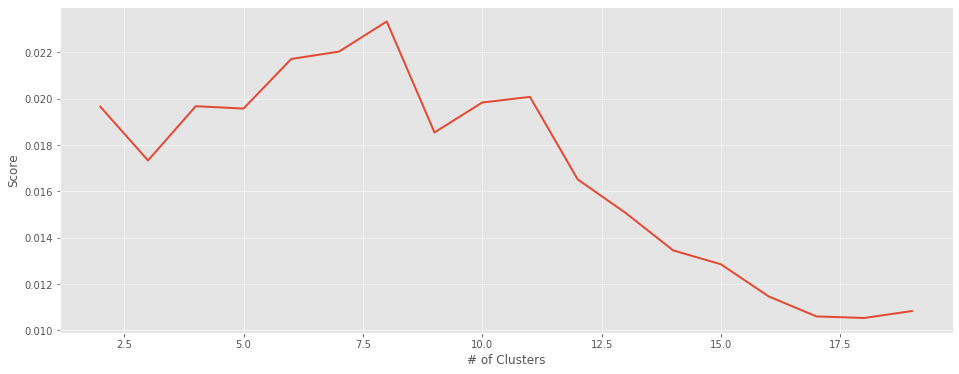

Max Value:
Cluster #     Cluster Score
17       5.497139

Min Value:
Cluster #     Cluster Score
11       4.384532


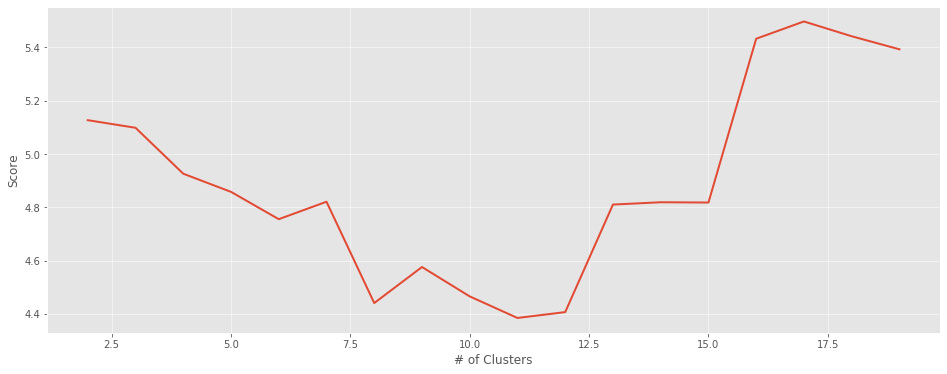

In [54]:
def plot_evaluation(y, x=cluster_cnt):
    """
    Plots the scores of a set evaluation metric. Prints out the max and min values of the evaluation scores.
    """
    
    # Creating a DataFrame for returning the max and min scores for each cluster
    df = pd.DataFrame(columns=['Cluster Score'], index=[i for i in range(2, len(y)+2)])
    df['Cluster Score'] = y
    
    print('Max Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].max()])
    print('\nMin Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].min()])
    
    # Plotting out the scores based on cluster count
    plt.figure(figsize=(16,6))
    plt.style.use('ggplot')
    plt.plot(x,y)
    plt.xlabel('# of Clusters')
    plt.ylabel('Score')
    plt.show()
    
# Running the function on the list of scores
plot_evaluation(s_scores)

plot_evaluation(db_scores)

In [59]:
hac = AgglomerativeClustering(n_clusters=12)

# Fitting
hac.fit(df_pca)

# Getting cluster assignments
cluster_assignments = hac.labels_

# Unscaling the categories then replacing the scaled values
#df = df[['Bios']].join(pd.DataFrame(scaler.inverse_transform(df.drop('Bios', axis=1)), columns=df.columns[1:], index=df.index))

# Assigning the clusters to each profile
df['Cluster #'] = cluster_assignments

# Viewing the dating profiles with cluster assignments
df

,Bios,Movies,TV,Religion,Music,Sports,Books,Politics,Cluster #
0,"[typical, twitter, fanatic, infuriatingly, hum...",0.555556,0.333333,0.444444,0.111111,0.333333,0.666667,0.777778,6
1,"[web, junkie, analyst, infuriatingly, humble, ...",0.777778,1.000000,0.555556,0.111111,1.000000,0.444444,0.000000,0
2,"[avid, web, maven, food, practitioner, gamer, ...",0.111111,0.222222,0.666667,0.555556,0.666667,0.555556,0.444444,2
3,"[twitteraholic, extreme, web, fanatic, food, b...",0.555556,0.222222,0.777778,0.888889,0.222222,0.666667,0.666667,6
4,"[bacon, enthusiast, fall, lot, freelance, soci...",0.666667,0.666667,0.666667,0.444444,0.333333,0.666667,0.333333,6
...,...,...,...,...,...,...,...,...,...
6595,"[typical, pop, culture, nerd, infuriatingly, h...",0.777778,1.000000,0.000000,0.000000,0.222222,0.222222,0.444444,2
6596,"[avid, web, junkie, lifelong, alcohol, guru, h...",0.444444,0.333333,0.666667,0.333333,0.777778,0.777778,0.222222,3
6597,"[music, ninja, bacon, fanatic, reader, total, ...",0.111111,0.444444,0.000000,0.444444,1.000000,0.222222,0.555556,0
6598,"[communicator, bacon, lover, award-winning, in...",0.666667,0.222222,0.000000,0.333333,0.888889,1.000000,0.111111,3
